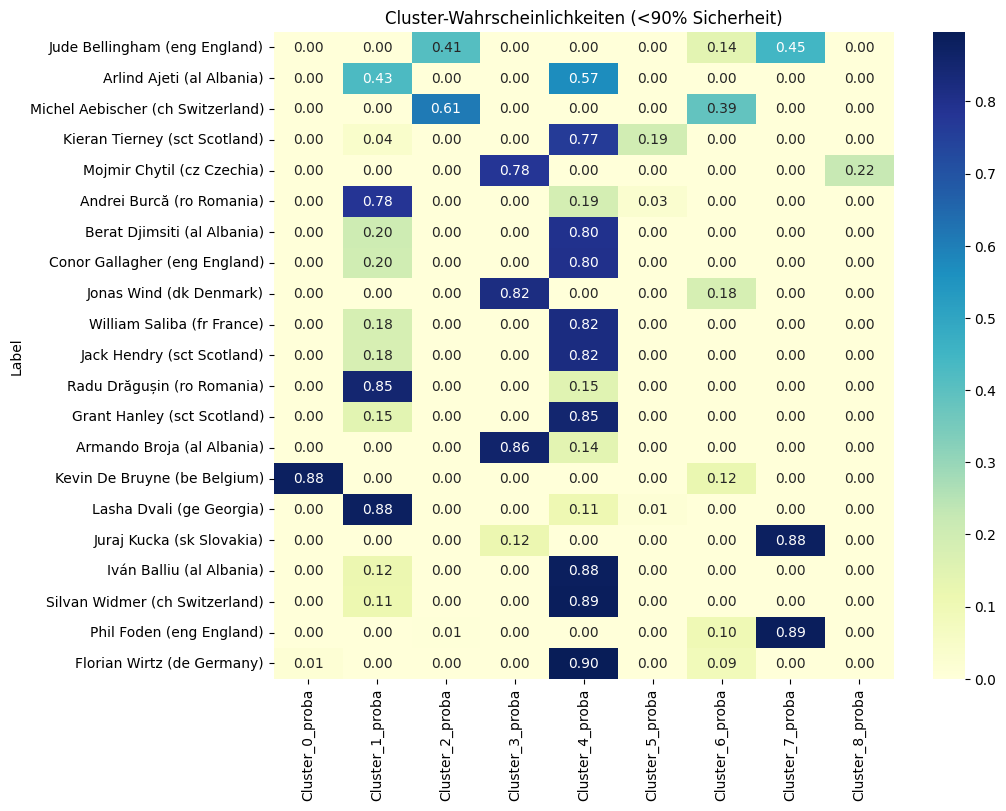

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# CSV laden
df_soft = pd.read_csv(r"..\results\players_gmm_soft_assignments.csv")

# Spalten mit Wahrscheinlichkeiten erkennen
prob_cols = [c for c in df_soft.columns if "_proba" in c]

# Spieler mit weniger als 90% sicherer Zuordnung finden
low_conf_players_sorted = (
    df_soft[df_soft["Cluster_confidence"] < 0.9]
    .sort_values("Cluster_confidence")
)

# Spielername + Land kombinieren
if "Squad" in low_conf_players_sorted.columns:
    low_conf_players_sorted["Label"] = low_conf_players_sorted["Player"] + " (" + low_conf_players_sorted["Squad"] + ")"
else:
    low_conf_players_sorted["Label"] = low_conf_players_sorted["Player"]

# Nur Wahrscheinlichkeiten + kombinierter Name
heat_df = low_conf_players_sorted[["Label"] + prob_cols].set_index("Label")

# Heatmap zeichnen
plt.figure(figsize=(10, len(heat_df) * 0.4))
sns.heatmap(heat_df, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Cluster-Wahrscheinlichkeiten (<90% Sicherheit)")
plt.show()


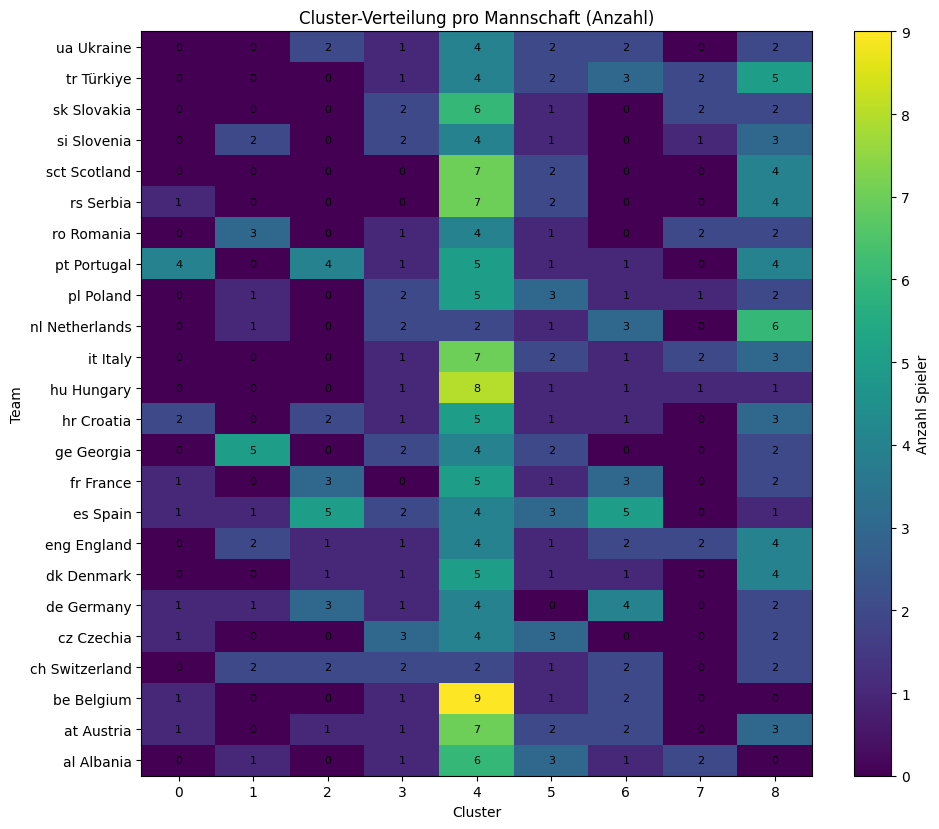

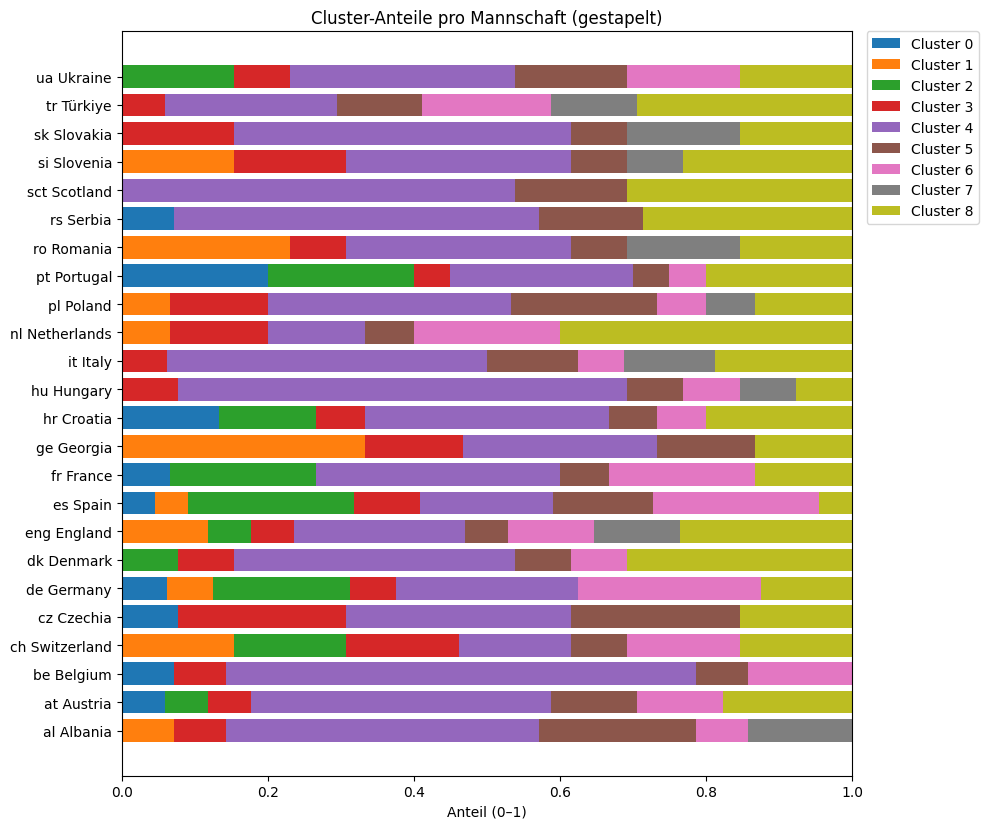

In [2]:
# Basistabellen: Counts & Anteile je Team × Cluster 
counts = pd.crosstab(df_soft["Squad"], df_soft["Cluster_hard"]).sort_index()
perc   = counts.div(counts.sum(axis=1).replace(0, np.nan), axis=0)  # zeilenweise Anteile (0..1)

# Falls es sehr viele Teams gibt: auf Top-N Teams nach Kadergröße begrenzen (z.B. 30)
TOP_N = 30
top_teams = counts.index  
if len(top_teams) > TOP_N:
    top_teams = top_teams[:TOP_N]

counts_top = counts.loc[top_teams]
perc_top   = perc.loc[top_teams]


# Heatmap (Absolutwerte) 
counts_top_rev = counts_top.iloc[::-1]  # Daten umdrehen

fig, ax = plt.subplots(figsize=(10, max(6, 0.35*len(counts_top_rev))))
im = ax.imshow(counts_top_rev.values, aspect="auto")

# Achsenbeschriftungen an umgedrehte Reihenfolge anpassen
ax.set_xticks(range(counts_top_rev.shape[1]))
ax.set_yticks(range(counts_top_rev.shape[0]))
ax.set_xticklabels(counts_top_rev.columns)
ax.set_yticklabels(counts_top_rev.index)  # Index ist jetzt schon umgedreht

plt.colorbar(im, ax=ax, label="Anzahl Spieler")

# Zellen beschriften
for i in range(counts_top_rev.shape[0]):
    for j in range(counts_top_rev.shape[1]):
        val = counts_top_rev.iat[i, j]
        ax.text(j, i, str(val), ha="center", va="center", fontsize=8)

ax.set_title("Cluster-Verteilung pro Mannschaft (Anzahl)")
ax.set_xlabel("Cluster")
ax.set_ylabel("Team")
plt.tight_layout()
plt.show()


# Gestapelte Balken (Anteile)
fig, ax = plt.subplots(figsize=(10, max(6, 0.35*len(perc_top))))
bottom = np.zeros(len(perc_top))
x = np.arange(len(perc_top))

for c in perc_top.columns:
    ax.barh(x, perc_top[c].values, left=bottom)
    bottom += perc_top[c].values

ax.set_yticks(x)
ax.set_yticklabels(perc_top.index)
ax.set_xlim(0, 1)
ax.set_xlabel("Anteil (0–1)")
ax.set_title("Cluster-Anteile pro Mannschaft (gestapelt)")
ax.legend([f"Cluster {c}" for c in perc_top.columns], bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0.)
plt.tight_layout()
plt.show()

# ---- Optional: Tabellen exportieren ----
# counts.to_csv("team_cluster_counts.csv")
# perc.round(3).to_csv("team_cluster_shares.csv")
